# Quick Start Guide for Inelastic Scattering
Let’s start by running an inelastic scattering reaction on {{bfrescox}} using a canonical system from the [{{fresco}}](https://www.fresco.org.uk/examples/index.html) examples: $^{4}$ He inelastic scattering on a $^{12}$ C target at a laboratory energy of 100 MeV. Note, however, that we are running a full closed-couplings inelastic scattering calculation, whereas the example in [{{fresco}}](https://www.fresco.org.uk/examples/index.html) uses the Distorted Wave Born Approximation. 

Just like for elastic scattering, the {{bfrescox}} package contains a built-in **template** and {{frescox}} **input** generator with a Python interface for inelastic scattering. For the moment, the built-in capabilities allow only for inclusion of target deformations in the calculation, for projectile deformations and other more complex reaction systems involving coupled-channels, we refer the use to the User-Defined-Template guide. 

In [91]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import inspect
import pandas as pd
import json

with open("MatplotlibEsthetics.json", "r") as fptr:
    esthetics = json.load(fptr)

plt.style.use(esthetics["style"])
FONTSIZE      = esthetics["fontsize"]
TICK_FONTSIZE = esthetics["tick_fontsize"]
MARKERSIZE    = esthetics["markersize"]
LINEWIDTH     = esthetics["linewidth"]

## Generating the {{frescox}} Input

Same as for elastic scattering, the construction of a {{frescox}} inelastic **input file** involves two main steps:

1. **Create the {{frescox}} template**  
   Begin by setting up a **template** that defines the overall scattering system.  
   The template is a {{frescox}} namelist file that specifies:
   - the target **mass** and **charge**, as well as the **spin** and **parity** of its excited states.
   - the projectile **mass**, **charge** and **spin**
   - the **laboratory energy**
   - the number of **partial waves**
   - the **Coulomb radius**
   - the order of the **tensor couplings** to be included

   At this stage, the interaction parameters are left as **placeholders** to be filled in later (the deformation strength parameter is also treated as a **placeholder**).  


2. **Generate the complete {{frescox}} input file**  
   Once the **template** is defined and all system properties are specified, you can replace the **placeholder** parameters with their actual numerical values.  
   This produces a fully specified **input file** ready to be passed to {{frescox}} for the reaction calculation.


For subsequent calculations involving the same reaction system, you only need to perform step&nbsp;2 — reusing the existing **template** and updating the parameter values as needed.

 Let's see how this works, step by step. Begin by assigning appropriate names to the {{frescox}} **template**, **input** and **output** files.

In [92]:
# Name the general template file for your problem
template_name = "12C_4He_inelastic_example.template"

# Name the frescox input file to be generated
frescox_input = "12C_4He_inelastic_example.in"
#Name the frescox output file to be generated (the standard output name)
frescox_output = "12C_4He_inelastic_example.out"

### 1. Create the {{frescox}} template
Now let's define the target **mass**, **spin** and **excited states**,  as well as the projectile **mass** and **spin**. One must also specify the laboratory **energy**, **number of partial waves**, **Coulomb radius** of the system, and the **tensor couplings**. We can do all of this easily using a Python dictionary.  
This information will be used by the `bfrescox.generate_inelastic_template()` method to automatically populate the {{frescox}} **template**.


In [93]:
import bfrescox

# Define the inelastic scattering system coupling 12C(0+) and 12C(2+)
configuration_template_inelastic = {
          "mass_t" : 12,             # mass of target nucleus
          "charge_t" : 6,            # charge of target nucleus
          "mass_p" : 4,              # mass of projectile
          "charge_p" : 2,            # charge of projectile
          "spin_p" : 0,              # spin of projectile
          "E_lab": 100,              # lab energy in MeV
          "J_tot_min": 0.0,          # minimum  number of total angular momentum (partial waves)
          "J_tot_max": 40.0,         # maximum  number of total angular momentum (partial waves)
          "R_Coulomb": 1.2,          # Coulomb radius parameter in fm
          "I_states": [0.0, 2.0],    # spin states of target nucleus
          "E_states": [0, 4.43],     # excitation energies of target nucleus in MeV
          "Pi_states": [1, 1],       # parities of target nucleus states (+1 or -1)
          "multipoles": [2],         # multipoles of the couplings included (one can add as many as desired = [0,2,4,...])
          "R_match": 20.0,           # matching radius in fm
          "step_size": 0.05,         # step size in fm
          "reaction_name": "alpha+c12 -> alpha+c12* @ 100 MeV; nuc def"
        }

# Generate the template for your system and set up the frescox input file
bfrescox.generate_inelastic_template(
                template_name, **configuration_template_inelastic
            )

We now have generated the {{frescox}} inelastic *template** for the system! Let's see what this looks like.

In [94]:
with open(template_name, "r") as temp:
    generated_content = temp.read()

print("Generated Frescox Inelastic Template:")
print("-----------------------------------")
print(generated_content)

Generated Frescox Inelastic Template:
-----------------------------------
alpha+c12 -> alpha+c12* @ 100 MeV; nuc def
NAMELIST
&FRESCO hcm=0.05 rmatch=20.0
    jtmin=0.0 jtmax=40.0 absend= 0.01
  thmin=0.00 thmax=180.00 thinc=1.00
    iter=0 ips=0.0 iblock=2 chans=1 smats=2  xstabl=1
  wdisk=2
    elab(1)=100 treneg=1 /

 &PARTITION namep='projectile' massp=4 zp=2
            namet='target'   masst=12 zt=6 qval=0.0 nex=2  /
 &STATES jp=0.0 bandp=1 ep=0.0000 cpot=1 jt=0.0 bandt=1 et=0 /
 &STATES copyp=1         cpot=1 jt=2.0 bandt=1 et=4.43 /
&partition /

 &POT kp=1 ap=4 at=12 rc=1.2  /
 &POT kp=1 type=1  p1=@V@ p2=@r@ p3=@a@ p4=@W@ p5=@rw@ p6=@aw@ /
&POT kp=1 type=11 p2=@delta_2@ /
 &POT kp=1 type=2  p1=@Vs@ p2=@rs@ p3=@as@ p4=@Ws@ p5=@rws@ p6=@aws@ /
&POT kp=1 type=11 p2=@delta_2@ /
 &POT kp=1 type=3  p1=@Vso@ p2=@rso@ p3=@aso@ p4=@Wso@ p5=@rwso@ p6=@awso@ /

 &pot /
 &overlap /
 &coupling /
 


Great! All system quantities are now defined and in place for the reaction we want to run. The parameter **placeholders** are put in place, each one is labeled as $ \texttt{<parameter name>} $ in the **template**. Note that for the deformation strength, we have an added parameter called $ \texttt{ delta\_2 } $ , for tensor couplings that include more than just the quadrupole term, more parameters are dynamically added!


All that is left is to replace the **placeholder** interaction parameters in the template with their actual numerical values. Let's do that next.

### 2. Generate the complete {{frescox}} **input file**

Similar to how we set up our system. We will pass can arrange the parameter values in a Python Dictionary. This information will be used by the ` bfrescox.Configuration.from_template()` method to automatically generate the final {{frescox}} inelastic input.

In [95]:
# Define the deformed model parameters for inelastic scattering, currently using the rigid rotor model in BFrescox
parameters_inelastic =  {
                    "V": 40.0,
                    "r": 1.2,
                    "a": 0.65,
                    "W": 10.0,
                    "rw": 1.2,
                    "aw": 0.5,
                    "Vso": 0,
                    "rso": 1.0,
                    "aso": 0.65,
                    "Wso": 0,
                    "rwso": 1.0,
                    "awso": 0.65,
                    "Vs": 0,
                    "rs": 1.2,
                    "as": 0.5,
                    "Ws": 6,
                    "rws": 1.2,
                    "aws": 0.5,
                    "delta_2": 1.3  # deformation parameter for couplings, e.g., delta_2 for quadrupole, delta_3 for octupole, etc.
}


# Create the frescox input file by filling in the previously generated template with parameters
cfg = bfrescox.Configuration.from_template(
                    template_name,
                    frescox_input,
                    parameters_inelastic,
                    overwrite=True,
                )

We now have generate the {{frescox}} inelastic **input file** from the **template**! Let's see what this looks like.

In [96]:
with open(frescox_input, "r") as input:
    generated_content = input.read()

print("Generated Frescox Inelastic Input:")
print("-----------------------------------")
print(generated_content)

Generated Frescox Inelastic Input:
-----------------------------------
alpha+c12 -> alpha+c12* @ 100 MeV; nuc def
NAMELIST
&FRESCO hcm=0.05 rmatch=20.0
    jtmin=0.0 jtmax=40.0 absend= 0.01
  thmin=0.00 thmax=180.00 thinc=1.00
    iter=0 ips=0.0 iblock=2 chans=1 smats=2  xstabl=1
  wdisk=2
    elab(1)=100 treneg=1 /

 &PARTITION namep='projectile' massp=4 zp=2
            namet='target'   masst=12 zt=6 qval=0.0 nex=2  /
 &STATES jp=0.0 bandp=1 ep=0.0000 cpot=1 jt=0.0 bandt=1 et=0 /
 &STATES copyp=1         cpot=1 jt=2.0 bandt=1 et=4.43 /
&partition /

 &POT kp=1 ap=4 at=12 rc=1.2  /
 &POT kp=1 type=1  p1=40.0 p2=1.2 p3=0.65 p4=10.0 p5=1.2 p6=0.5 /
&POT kp=1 type=11 p2=1.3 /
 &POT kp=1 type=2  p1=0 p2=1.2 p3=0.5 p4=6 p5=1.2 p6=0.5 /
&POT kp=1 type=11 p2=1.3 /
 &POT kp=1 type=3  p1=0 p2=1.0 p3=0.65 p4=0 p5=1.0 p6=0.65 /

 &pot /
 &overlap /
 &coupling /
 


Awesome! We have now generated the {{frescox}} inelastic **input file** using the built-in {{bfrescox}} template and input generators.

## Running inelastic scattering with {{bfrescox}}

Now that we have generated the {{frescox}} **input file**, running the inelastic scattering calculation is extremely easy!

In [97]:
# Run the frescox simulation
bfrescox.run_simulation(cfg, frescox_output, cwd=".", overwrite=True)


Done! All we need to do is parse the results and extract the physical quantities we want. Let's focus on extracting the cross sections from the **output files**.

## Parsing Inelastic Scattering Cross Sections

There are several ways to obtain the cross sections. They can be extracted either from the standard {{frescox}} **output file** or from the **fort.16** file.  
Currently, {{bfrescox}} retrieves them from the standard {{frescox}} output. It can extract the results either in **mb/sr** or as a **ratio to the Rutherford** cross section (when available).  

The extracted cross sections are returned as a DataFrame for convenient analysis and visualization.  

Let's extract them for our example case.

In [98]:
# Parse the frescox output file to extract differential cross section results
results_df = bfrescox.parse_differential_xs.absolute_mb_per_sr(
                            frescox_output
                        )

# Can also parse the results as ratio to Rutherford WHEN AVAILABLE
results_df_r2r = bfrescox.parse_differential_xs.ratio_to_rutherford(
                            frescox_output
                        )

Let's see what the cross sections look like!

In [99]:
# Note that ration to Rutherford is used only for the elastic channel, 
# The results are parsed in a pandas DataFrame
display(results_df.head())
display(results_df_r2r.head())

,differential_xs_absolute_mb_per_sr
angle_degrees,
0.01,5.720590e+14
1.00,4.908692e+06
2.00,2.214236e+05
3.00,4.471694e+04
4.00,2.355925e+04


,differential_xs_ratio_to_rutherford
angle_degrees,
0.01,1.000015
1.00,0.858043
2.00,0.619186
3.00,0.632884
4.00,1.053451


Cross sections parsed with `bfrescox.parse_differential_xs.ratio_to_rutherford` return a DataFrame for the elastic channel only (the channel where target remains in its ground state).  
In contrast, `bfrescox.parse_differential_xs.absolute_mb_per_sr` returns a DataFrame with both elastic (target in (0+) and inelastic (target excited to 2+) cross sections.


## Visualizing cross sections and benchmarks

Now that we have the cross sections in a Dataframe, let's visualize them. We should also make sure that our calculation using the {{bfrescox}} build matches a calculation using the standard {{frescox}} installation. 

Let's begin looking at the cross sections. 

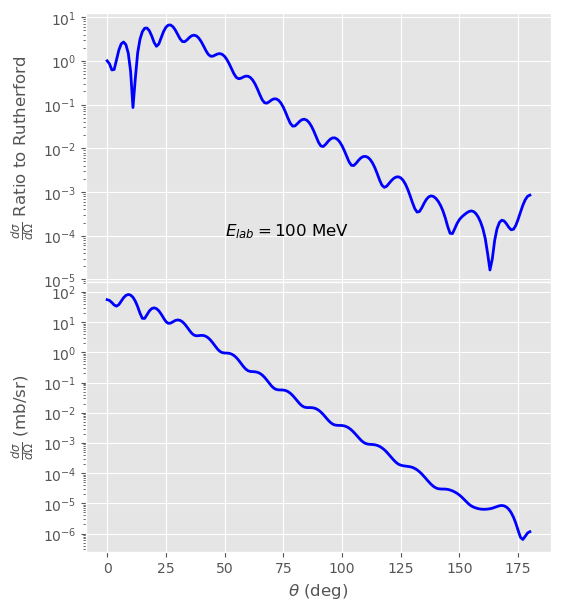

In [100]:
# Plot the results
angles_deg = results_df.index.to_numpy()
diff_xs_mb_per_sr = results_df["differential_xs_absolute_mb_per_sr"].to_numpy()
diff_xs_r2r = results_df_r2r["differential_xs_ratio_to_rutherford"].to_numpy()

angles = angles_deg[:181]
elastic_r2r = diff_xs_r2r
inelastic_mb_sr = diff_xs_mb_per_sr[181:]

# Create figure and axes that share all axes
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(6, 7),
    sharex=True, sharey=False
)
plt.subplots_adjust(hspace=0)  # remove gap

# Global font size settings for ticks
for ax in (ax1, ax2):
    ax.tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)  # increase tick font size
    ax.tick_params(axis='both', which='minor', labelsize=TICK_FONTSIZE)  # optional minor tick size


ax1.plot(angles, elastic_r2r, lw=LINEWIDTH, color='blue')
ax1.set_yscale('log')
ax1.set_ylabel(r"$\frac{d\sigma}{d\Omega}$ Ratio to Rutherford", fontsize=FONTSIZE)


ax2.plot(angles, inelastic_mb_sr, lw=LINEWIDTH, color='blue')
ax2.set_yscale('log')
ax2.set_ylabel(r"$\frac{d\sigma}{d\Omega}$ (mb/sr)", fontsize=FONTSIZE)
ax2.set_xlabel(r"$\theta$ (deg)", fontsize=FONTSIZE)
ax1.text(50.0, 1e-4, r"$E_{lab} = 100$ MeV",
        fontsize=FONTSIZE, color='black')


plt.show()

Great! These look nice. 

Let's check our {{bfrescox}} results against a standard {{frescox}} installation. Let's load the benchmark results and visualize them against our {{bfrescox}} calculation.

In [101]:
# We can benchmark our results against the results obtained from a standard Frescox installation
# Locate BFrescox test data directory
data_path = (
    Path(inspect.getfile(bfrescox))
    .resolve()
    .parent
    .joinpath("tests", "TestData")
)

# Load the baseline cross section
baseline_file = data_path /  "12C_4He_inelastic_PointA_fort16.pkl"
expected = pd.read_pickle(baseline_file)

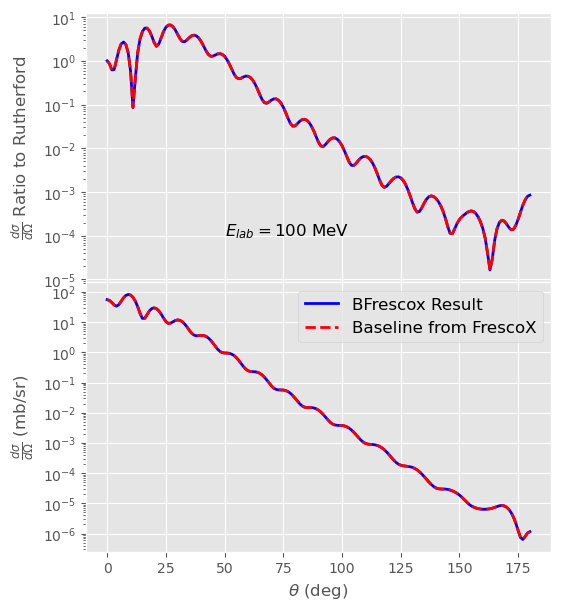

In [102]:
# load the cross section values to benchmark the inelastic and elastic results
elastic_expected = expected["channel_1"]["sigma"].to_numpy()
inelastic_expected = expected["channel_2"]["sigma"].to_numpy()

# Create figure and axes that share all axes
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(6, 7),
    sharex=True, sharey=False
)
plt.subplots_adjust(hspace=0)  # remove gap

# Global font size settings for ticks
for ax in (ax1, ax2):
    ax.tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)  # increase tick font size
    ax.tick_params(axis='both', which='minor', labelsize=TICK_FONTSIZE)  # optional minor tick size


ax1.plot(angles, elastic_r2r, lw=LINEWIDTH, color='blue')
ax1.plot(angles, elastic_expected, lw=LINEWIDTH, color='red', ls='--')
ax1.set_yscale('log')
ax1.set_ylabel(r"$\frac{d\sigma}{d\Omega}$ Ratio to Rutherford", fontsize=FONTSIZE)


ax2.plot(angles, inelastic_mb_sr, lw=LINEWIDTH, color='blue', label='BFrescox Result')
ax2.plot(angles, inelastic_expected, lw=LINEWIDTH, color='red', ls='--', label='Baseline from FrescoX')
ax2.set_yscale('log')
ax2.set_ylabel(r"$\frac{d\sigma}{d\Omega}$ (mb/sr)", fontsize=FONTSIZE)
ax2.set_xlabel(r"$\theta$ (deg)", fontsize=FONTSIZE)
ax1.text(50.0, 1e-4, r"$E_{lab} = 100$ MeV",
        fontsize=FONTSIZE, color='black')

plt.legend(fontsize=FONTSIZE)

plt.show()

Looks pretty good! Lets generate some error plots for each channel.

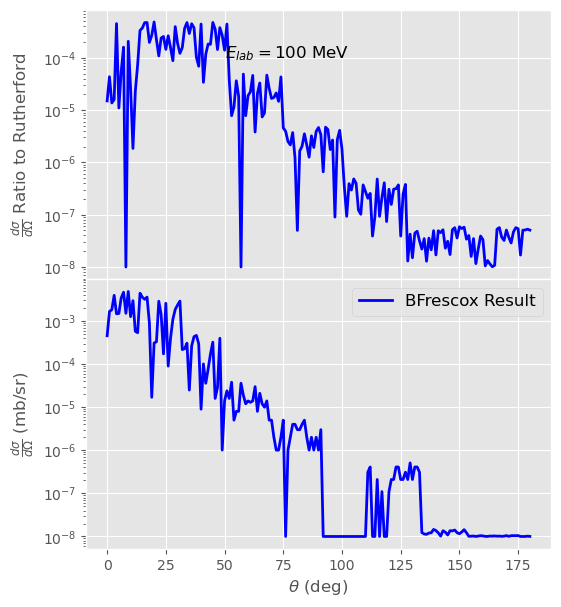

In [103]:
# load the cross section values to benchmark the inelastic and elastic results
elastic_expected = expected["channel_1"]["sigma"].to_numpy()
inelastic_expected = expected["channel_2"]["sigma"].to_numpy()

regularization_factor = 1e-8

# Create figure and axes that share all axes
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(6, 7),
    sharex=True, sharey=False
)
plt.subplots_adjust(hspace=0)  # remove gap

# Global font size settings for ticks
for ax in (ax1, ax2):
    ax.tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)  # increase tick font size
    ax.tick_params(axis='both', which='minor', labelsize=TICK_FONTSIZE)  # optional minor tick size


ax1.plot(angles, np.abs(elastic_r2r-elastic_expected) + regularization_factor, lw=LINEWIDTH, color='blue')
ax1.set_yscale('log')
ax1.set_ylabel(r"$\frac{d\sigma}{d\Omega}$ Ratio to Rutherford", fontsize=FONTSIZE)


ax2.plot(angles, np.abs(inelastic_mb_sr-inelastic_expected) + regularization_factor, lw=LINEWIDTH, color='blue', label='BFrescox Result')
ax2.set_yscale('log')
ax2.set_ylabel(r"$\frac{d\sigma}{d\Omega}$ (mb/sr)", fontsize=FONTSIZE)
ax2.set_xlabel(r"$\theta$ (deg)", fontsize=FONTSIZE)
ax1.text(50.0, 1e-4, r"$E_{lab} = 100$ MeV",
        fontsize=FONTSIZE, color='black')

plt.legend(fontsize=FONTSIZE)

plt.show()

Interesting! There seems to be small errors between the benchmark and the current calculation. No need to be alarmed, these come from the way the benchmark results were parsed. We are parsing our cross sections from the standard {{frescox}} output, whereas the benchmark results were parsed from the fort.16 file, which contains some rounding.

Our results, however, do look quite close. Let's now parse the results using the fort.16 file. We will see that the differences between our calculation and the benchmark disappear. 

## Alternative results parsing
In {{bfrescox}} you can always parse your own results directly from the desired fort file with a function. For example for fort.16, the {{bfrescox}} package includes a low-level function that loads a significant amount of results not shown above.  Users can access some of this data directly using:

In [104]:
results = bfrescox.parse_fort16(Path("fort.16"))
display(results["channel_1"].head()) # elastic channel 
display(results["channel_2"].head()) # inelastic channel

,Theta,sigma
0,0.01,1.0000
1,1.00,0.8580
2,2.00,0.6192
3,3.00,0.6329
4,4.00,1.0530


,Theta,sigma
0,0.0,55.26
1,1.0,52.17
2,2.0,44.62
3,3.0,36.89
4,4.0,33.76


Let's compare these results to the benchmark!

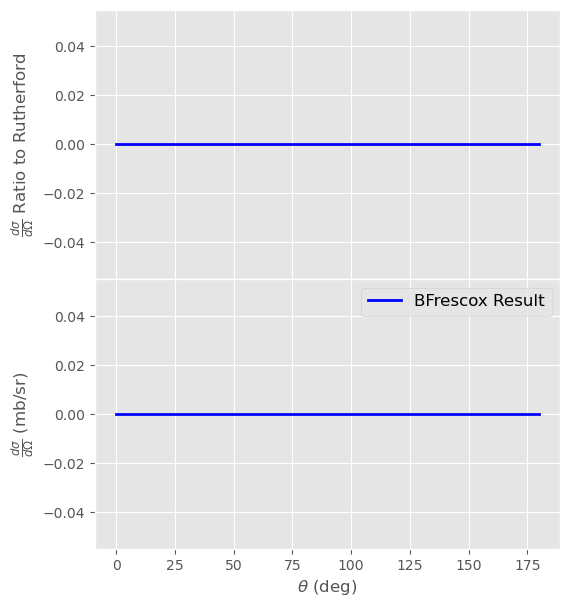

In [105]:
# load the cross section values to benchmark the inelastic and elastic results
elastic_from_fort = results["channel_1"]["sigma"].to_numpy()
inelastic_from_fort = results["channel_2"]["sigma"].to_numpy()


# Create figure and axes that share all axes
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(6, 7),
    sharex=True, sharey=False
)
plt.subplots_adjust(hspace=0)  # remove gap

# Global font size settings for ticks
for ax in (ax1, ax2):
    ax.tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)  # increase tick font size
    ax.tick_params(axis='both', which='minor', labelsize=TICK_FONTSIZE)  # optional minor tick size


ax1.plot(angles, np.abs(elastic_from_fort-elastic_expected), lw=LINEWIDTH, color='blue')
#ax1.set_yscale('log')
ax1.set_ylabel(r"$\frac{d\sigma}{d\Omega}$ Ratio to Rutherford", fontsize=FONTSIZE)


ax2.plot(angles, np.abs(inelastic_from_fort-inelastic_expected), lw=LINEWIDTH, color='blue', label='BFrescox Result')
#ax2.set_yscale('log')
ax2.set_ylabel(r"$\frac{d\sigma}{d\Omega}$ (mb/sr)", fontsize=FONTSIZE)
ax2.set_xlabel(r"$\theta$ (deg)", fontsize=FONTSIZE)
# ax1.text(50.0, 1e-4, r"$E_{lab} = 100$ MeV",
#         fontsize=FONTSIZE, color='black')

plt.legend(fontsize=FONTSIZE)

plt.show()

Great! As expected when we compare agains the benchmark parsing the results from the same output file of {{frescox}} we obtain the exact same result!